In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.constants as scc
from scipy.integrate import odeint, solve_ivp

In [2]:
from scipy.integrate import odeint, solve_ivp

# gaussian beam intensity

In [14]:
def gaussian_beam_efield(x,y,z,w_x,w_y,L,A0=1):
    '''
    A0 is the amplitude factor. All parameters in SI unit.
    NOT considering polarizaiton direction here
    '''
    zRx = np.pi*w_x**2/L
    zRy = np.pi*w_y**2/L
    wxz = w_x*np.sqrt(1+(z/zRx)**2)
    wyz = w_y*np.sqrt(1+(z/zRy)**2)
    Rzx_times_z = (z**2+(zRx)**2)
    Rzy_times_z = (z**2+(zRy)**2)
    k = 2*np.pi/L
    return A0 * np.sqrt(w_x/wxz * w_y/wyz) * np.exp(-(x**2/wxz**2+y**2/wyz**2)) * \
        np.exp(-1j*( k*z+k*(x**2*z/(2*Rzx_times_z)+y**2*z/(2*Rzy_times_z)) - 1/2*np.arctan(z/zRx) - 1/2*np.arctan(z/zRy) ))

In [15]:
def gaussian_beam_intensity(x,y,z,w_x,w_y,L,U0=1):
    '''
    A0 is the amplitude factor. All parameters in SI unit.
    NOT considering polarizaiton direction here
    '''
    zRx = np.pi*w_x**2/L
    zRy = np.pi*w_y**2/L
    wxz = w_x*np.sqrt(1+(z/zRx)**2)
    wyz = w_y*np.sqrt(1+(z/zRy)**2)
    return U0 * w_x/wxz * w_y/wyz * np.exp(-2*(x**2/wxz**2+y**2/wyz**2))

In [142]:
def gaussian_beam_potential(x,y,z,w_x,w_y,L,U0=1):
    '''
    A0 is the amplitude factor. All parameters in SI unit.
    NOT considering polarizaiton direction here
    '''
    return gaussian_beam_potential(x,y,z,w_x,w_y,L,U0)

In [17]:
def gaussian_beam_intensity_gradient(x,y,z,w_x,w_y,L,U0=1):
    '''
    A0 is the amplitude factor. All parameters in SI unit.
    NOT considering polarizaiton direction here
    '''
    zRx = np.pi*w_x**2/L
    zRy = np.pi*w_y**2/L
    wxz = w_x*np.sqrt(1+(z/zRx)**2)
    wyz = w_y*np.sqrt(1+(z/zRy)**2)
    common_prefactor = U0 * w_x/wxz * w_y/wyz * np.exp(-2*(x**2/wxz**2+y**2/wyz**2))
    return common_prefactor*np.array([(-4*x/wxz**2), (-4*y/wyz**2), (-z/(wxz/w_x*zRx)**2 -z/(wyz/w_y*zRy)**2)])

## test plot intensity and graident

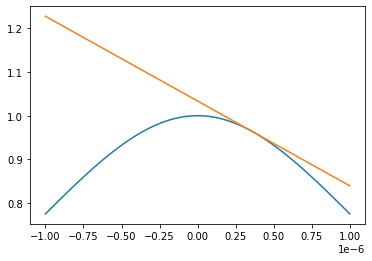

In [25]:
zz = np.linspace(-1e-6,1e-6, 101)
kwargs = {'w_x':0.7e-6, 'w_y':0.7e-6, 'L':830e-9}
plt.plot(zz, gaussian_beam_intensity(0,0,zz,**kwargs))
_idx_ = 68
plt.plot(zz, (zz-zz[_idx_])*gaussian_beam_intensity_gradient(0,0,zz[_idx_],**kwargs)[2]+gaussian_beam_intensity(0,0,zz[_idx_],**kwargs))

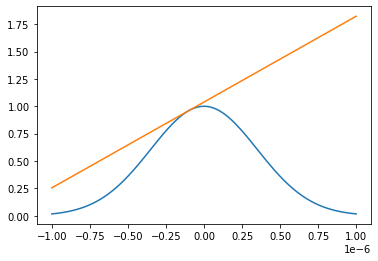

In [29]:
xx = np.linspace(-1e-6,1e-6, 101)
kwargs = {'w_x':0.7e-6, 'w_y':0.7e-6, 'L':830e-9}
plt.plot(xx, gaussian_beam_intensity(xx,0,0,**kwargs))
_idx_ = 45
plt.plot(xx, (xx-xx[_idx_])*gaussian_beam_intensity_gradient(xx[_idx_],0,0,**kwargs)[0]+gaussian_beam_intensity(xx[_idx_],0,0,**kwargs))

# time evolution

In [77]:
def gaussian_potential_propagation(t, R_vec,w_x,w_y,L,U0=1, m=87*scc.u):
    x,y,z,vx,vy,vz = R_vec
    dx = vx
    dy = vy
    dz = vz
    fx,fy,fz = -gaussian_beam_intensity_gradient(x,y,z,w_x,w_y,L,U0)
    dvx = fx/m
    dvy = fy/m + 9.8 # add gravity, g=9.8m/s^2
    dvz = fz/m
    return [dx,dy,dz,dvx,dvy,dvz]

In [78]:
args = (0.7e-6, 0.7e-6, 830e-9, -1e-3 * scc.k, 87 * scc.u)  # w_x,w_y,L,U0,m, Parameters of the system
Rvec0 = [0,100e-9,100e-9, np.sqrt(scc.k*10e-6/(87*scc.u)), 0, 0.0]  # Initial state of the system
t_span = (0.0, 1.0e-4)
t_eval = np.linspace(0,1e-4,1001)
result_solve_ivp = solve_ivp(gaussian_potential_propagation, t_span, y0=Rvec0, args=args, t_eval=t_eval)

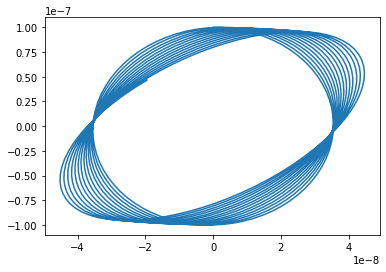

In [84]:
# plt.plot(result_solve_ivp.t, result_solve_ivp.y[0+2])
plt.plot(result_solve_ivp.y[0+0], result_solve_ivp.y[0+1])
# plt.plot(result_solve_ivp.t, result_solve_ivp.y[1])
# plt.plot(result_solve_ivp.t, result_solve_ivp.y[2])

NameError: name 'result_solve_ivp' is not defined

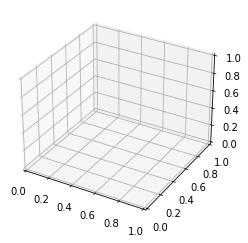

In [2]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.plot(result_solve_ivp.y[0, :],
        result_solve_ivp.y[1, :],
        result_solve_ivp.y[2, :])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# generate exponential distribution for time in the excited state

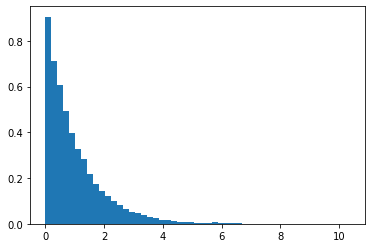

In [96]:
_t = np.random.default_rng().exponential(1,size=10000)
count, bins, _ = plt.hist(_t, bins=51, density = True) 

# sampling gaussian distributed position and velocity

In [143]:
def gaussian_beam_intensity(x,y,z,w_x,w_y,L,U0=1):
    '''
    A0 is the amplitude factor. All parameters in SI unit.
    NOT considering polarizaiton direction here
    '''
    zRx = np.pi*w_x**2/L
    zRy = np.pi*w_y**2/L
    wxz = w_x*np.sqrt(1+(z/zRx)**2)
    wyz = w_y*np.sqrt(1+(z/zRy)**2)
    return U0 * w_x/wxz * w_y/wyz * np.exp(-2*(x**2/wxz**2+y**2/wyz**2))

def gaussian_beam_potential(x,y,z,w_x,w_y,L,U0=1):
    '''
    A0 is the amplitude factor. All parameters in SI unit.
    NOT considering polarizaiton direction here
    '''
    return gaussian_beam_intensity(x,y,z,w_x,w_y,L,U0)

def gaussian_beam_intensity_gradient(x,y,z,w_x,w_y,L,U0=1):
    '''
    A0 is the amplitude factor. All parameters in SI unit.
    NOT considering polarizaiton direction here
    '''
    zRx = np.pi*w_x**2/L
    zRy = np.pi*w_y**2/L
    wxz = w_x*np.sqrt(1+(z/zRx)**2)
    wyz = w_y*np.sqrt(1+(z/zRy)**2)
    common_prefactor = U0 * w_x/wxz * w_y/wyz * np.exp(-2*(x**2/wxz**2+y**2/wyz**2))
    return common_prefactor*np.array([(-4*x/wxz**2), (-4*y/wyz**2), (-z/(wxz/w_x*zRx)**2 -z/(wyz/w_y*zRy)**2)])

def gaussian_potential_propagation(t, R_vec,w_x,w_y,L,U0=1, m=87*scc.u):
    x,y,z,vx,vy,vz = R_vec
    dx = vx
    dy = vy
    dz = vz
    fx,fy,fz = -gaussian_beam_intensity_gradient(x,y,z,w_x,w_y,L,U0)
    dvx = fx/m
    dvy = fy/m + 9.8 # add gravity, g=9.8m/s^2
    dvz = fz/m
    return [dx,dy,dz,dvx,dvy,dvz]


In [7]:
class monte_carlo_worker:
    def __init__(self, NA, lambda_l, U0_tweezer_inK, Ue_tweezer_inK, T, Gamma):
        self.lambda_l= lambda_l #m
        self.NA = NA
        self.T = T # K
        self.Gamma = Gamma # rad/s

        self.waist_twz = 0.42*self.lambda_l/self.NA #m
        self.U0_tweezer_inK = U0_tweezer_inK
        self.U0_tweezer_inJ = self.U0_tweezer_inK*scc.k
        self.Ue_tweezer_inK = Ue_tweezer_inK
        self.Ue_tweezer_inJ = self.Ue_tweezer_inK*scc.k
        
        self.omega_radial = np.sqrt(4*abs(self.U0_tweezer_inJ)/(87*scc.u*self.waist_twz**2)) # in rad/s
        self.omega_axial = self.omega_radial / (np.sqrt(2)*self.waist_twz*np.pi/lambda_l) # in rad/s
        
        self.tau = 1/self.Gamma

        print("Trap depth in uK: ", abs(self.U0_tweezer_inK*1e6))
        print("Trap depth of excited state in uK: ", abs(self.Ue_tweezer_inK*1e6))
        print("Atom temperature in uK: ", abs(self.T*1e6))
        print("Trap raidal freq (kHz): ", abs(self.omega_radial/ (2*np.pi)/1e3))
        print("Trap axial freq (kHz): ", abs(self.omega_axial/ (2*np.pi)/1e3))


    def delta_x_par (self, mass= 87*scc.u):
        return np.sqrt(scc.k*self.T / (mass * self.omega_axial**2) )

    def delta_x_perp (self, mass= 87*scc.u):
        return np.sqrt(scc.k*self.T / (mass * self.omega_radial**2) )

    def delta_v(self, mass= 87*scc.u):
        return np.sqrt(scc.k * self.T/ mass)

    def get_initial_params(self, num=1):
        # in here we assume that the z direction is the tweezer axis -> omega parallel
        (xi, yi)= np.random.normal(0, self.delta_x_perp(), 2*num).reshape(num,2).T
        zi= np.random.normal(0, self.delta_x_par(), num)
        (vxi, vyi, vzi) = np.random.normal(0, self.delta_v(), 3*num).reshape(num,3).T
        dt = np.random.default_rng().exponential(self.tau,size=num)
        return (dt, xi, yi, zi, vxi, vyi, vzi)

    def get_final_params(self, dts, xis,yis,zis, vxis, vyis, vzis, num=1):
        args = (self.waist_twz, self.waist_twz, self.lambda_l, self.Ue_tweezer_inJ, 87 * scc.u)  # w_x,w_y,L,U0,m, Parameters of the system
        xf=np.zeros(num);yf=np.zeros(num);zf=np.zeros(num);
        vxf=np.zeros(num);vyf=np.zeros(num);vzf=np.zeros(num)
        for idx, (dt,xi,yi,zi, vxi, vyi, vzi) in enumerate(zip(dts, xis,yis,zis, vxis, vyis, vzis)):
            Rvec0 = [xi,yi,zi, vxi, vyi, vzi]  # Initial state of the system
            t_span = (0.0, dt)
            t_eval = np.linspace(0,dt,1001)
            result_solve_ivp = solve_ivp(gaussian_potential_propagation, t_span, y0=Rvec0, args=args, t_eval=t_eval)
            _xf, _yf, _zf, _vxf, _vyf, _vzf = result_solve_ivp.y[:,-1]
            xf[idx]=_xf;yf[idx]=_yf;zf[idx]=_zf;
            vxf[idx]=_vxf;vyf[idx]=_vyf;vzf[idx]=_vzf
        return (xf, yf, zf, vxf, vyf, vzf )

    def get_final_K_energy (self, xf, yf, zf, vxf, vyf, vzf, mass = 87*scc.u):
            return mass / 2 * (vxf**2 + vyf**2 + vzf**2) + gaussian_beam_potential(
                xf, yf, zf, self.waist_twz, self.waist_twz, self.lambda_l, self.U0_tweezer_inJ
            )
    
    def get_survival_release_capture(self, trajectories_per_time=10000):
        '''
        :params T: temperature of atoms in the trap in S.I unit
        :params tweezer_depth: trap depth in the unit of K. The trap frequency is generated accordingly assuming NA = 0.5
        '''
        # trajectories_per_time = 10000
        initial_params = self.get_initial_params(num=trajectories_per_time)
        final_params = self.get_final_params(*initial_params, num=trajectories_per_time)
        final_K_energy = self.get_final_K_energy(*final_params)
        surv = final_K_energy<0
        return {'init_params': np.array(initial_params), 'final_params': np.array(final_params),
                'final_K_energy':final_K_energy,
                'surv':surv}

In [8]:
mcw = monte_carlo_worker(
    NA=0.43,
    lambda_l=830e-9,
    U0_tweezer_inK=-1e-3,
    Ue_tweezer_inK=0.5e-3,
    T=10e-6,
    Gamma=2 * np.pi * 6e6,
)

Trap depth in uK:  1000.0
Trap depth of excited state in uK:  500.0
Atom temperature in uK:  10.0
Trap raidal freq (kHz):  121.38042852663295
Trap axial freq (kHz):  27.970675901076024


In [9]:
res = mcw.get_survival_release_capture(10000)

NameError: name 'solve_ivp' is not defined

In [227]:
res['final_K_energy']/scc.k*1e3,res['surv'].mean()

(array([-0.98058479, -0.98599464, -0.95851673, ..., -0.98086453,
        -0.97961709, -0.95545905]),
 1.0)

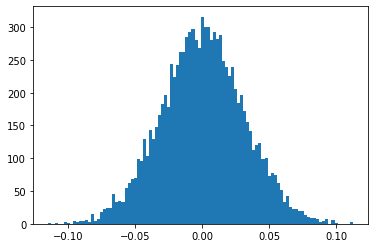

In [223]:
_=plt.hist(res['init_params'][4],bins=100)